In [1]:
import pickle
from copy import deepcopy

import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

import numpy as np; np.set_printoptions(suppress=True, linewidth=180)
import pandas as pd; pd.set_option('display.width', 500)
import matplotlib.pyplot as plt

from scipy.optimize import minimize


from plot_module import plot_ODE, plot_gillespie, plot_simulator_graph, plot_neuron_graph
from sim_param_from_network import names_from_network, gillespie_param_from_network, dataframes_from_network, ODE_from_network, start_state_from_nodes
from network_generate import net_gen_line_chain, net_gen_line_ring, net_gen_line_powlawtree, net_gen_hub_ring
from neuron_graph_transform import neuron_graph_transform, add_bioparam_attributes
from simulate import simulate_ode, simulate_gillespie
from graph_flow_solve import solve_subgraph_flux

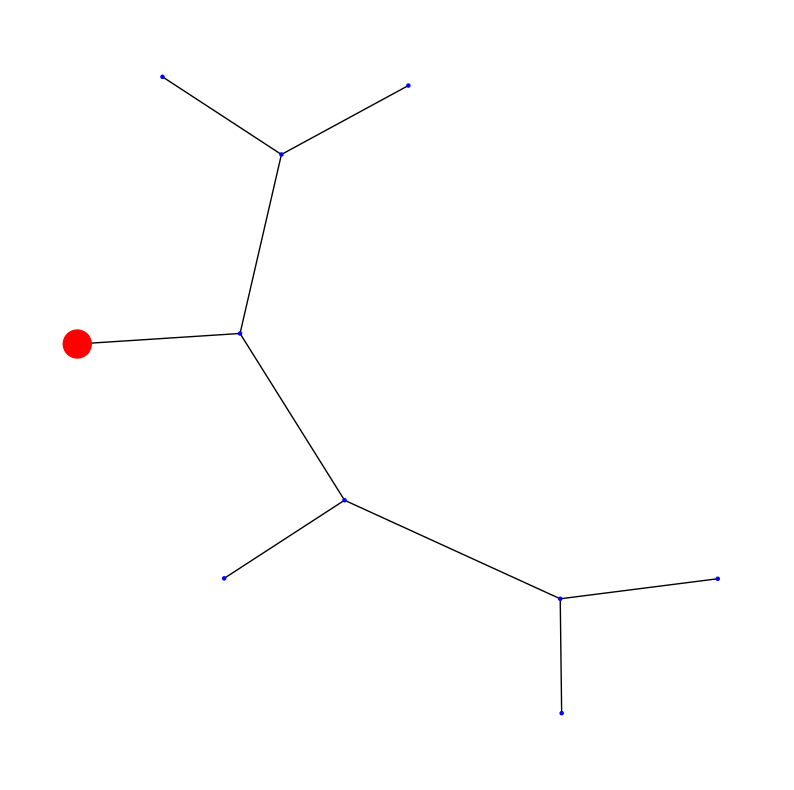

In [2]:
neuron_filename = 'm_hippocampus_NMO_97827.pkl'
with open(f'neuron_shape_data/{neuron_filename}', 'rb') as f:
    G = pickle.load(f)    
G.remove_node('319')

plot_neuron_graph(G)

In [3]:
SOMA_CB = 1.0
SOMA_BR = 3.2
SOMA_NSS = 500
SOMA_DIFFUSION = 0.4

DELTA = 0.5
DEATH_RATE = 0.4

AXON_TRNSP_ANT = 8
AXON_TRNSP_RET = 6

SWITCH_RATE_AR = 0.01
SWITCH_RATE_RA = 0.01

AXON_NODE_POP = 100
AXON_TERMINAL_INFLUX = 2*DEATH_RATE*AXON_NODE_POP
AXON_TERMINAL_EFFLUX = DEATH_RATE*AXON_NODE_POP

BIO_PARAM = {
    'soma_cb':SOMA_CB, 
    'soma_br':SOMA_BR, 
    'soma_nss':SOMA_NSS,
    'soma_diffusion':SOMA_DIFFUSION,
    
    'delta':DELTA, 
    'death_rate':DEATH_RATE, 
    
    'gamma_ant':AXON_TRNSP_ANT,
    'gamma_ret':AXON_TRNSP_RET,
    
    'axon_node_pop':AXON_NODE_POP,
    'axon_terminal_influx':AXON_TERMINAL_INFLUX,
    'axon_terminal_efflux':AXON_TERMINAL_EFFLUX,
    
    'switch_rate_ar':SWITCH_RATE_AR,
    'switch_rate_ra':SWITCH_RATE_RA,
    }

START_POP = [90, 20]

In [4]:
neuron_graph = neuron_graph_transform(G, transform_type='circle', n_soma_nodes=1)
neruon_graph = add_bioparam_attributes(neuron_graph, BIO_PARAM)
G = deepcopy(neuron_graph)

# for u, v, data in G.edges(data = True): print(f'{u}-{v}: {data}')
# for node, data in G.nodes(data = True): print(f'{node}: {data}')

> The undirected input graph has 10 nodes, and 9 edges, and 1 subgraph(s):
'axon with 9 nodes'
> the directed output graph has 14 nodes, and 18 edges


In [13]:
flux_dict = solve_subgraph_flux(G)

> Flux dataframe with unknowns:
        u      v direction flux_mat_i_j reverse_pair u_popsize flux_rate    net_flux
0     S0B  A116F   forward       (0, 1)            3     500.0      r[0]  500.0*r[0]
1   A116F  A165F   forward       (1, 3)            6      p[0]      r[1]   p[0]*r[1]
2   A116F  A187F   forward       (1, 7)           11      p[0]      r[2]   p[0]*r[2]
3   A116R    S0B   reverse       (2, 0)                   p[1]      r[3]   p[1]*r[3]
4   A165F  A174T   forward       (3, 5)            7      p[2]      r[4]        80.0
5   A165F  A181T   forward       (3, 6)            8      p[2]      r[5]        80.0
6   A165R  A116R   reverse       (4, 2)                   p[3]      r[6]   p[3]*r[6]
7   A174T  A165R   reverse       (5, 4)                  100.0       0.4        40.0
8   A181T  A165R   reverse       (6, 4)                  100.0       0.4        40.0
9   A187F  A208T   forward       (7, 9)           12      p[4]      r[7]        80.0
10  A187F  A221F   forward      (

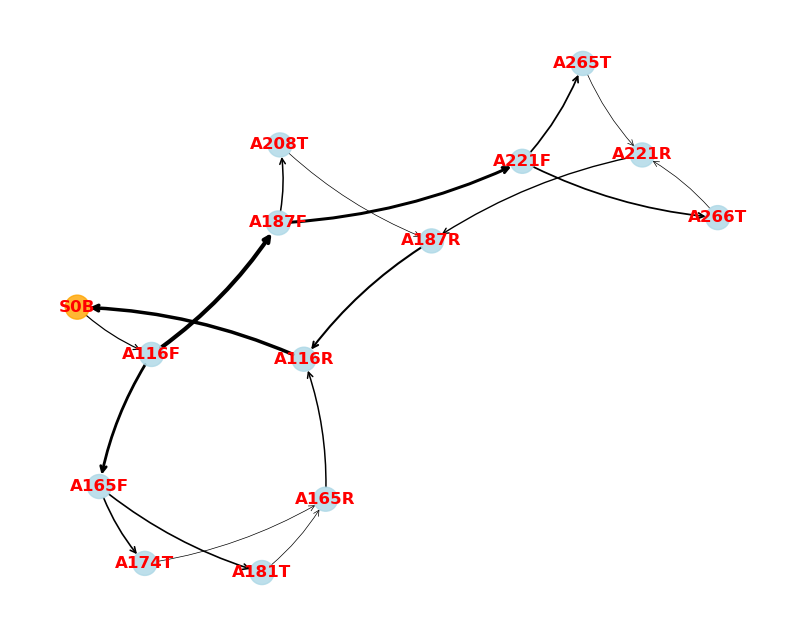

In [14]:
# update rates
nx.set_edge_attributes(G, flux_dict, 'rate')
plot_simulator_graph(G)

In [15]:
TIME_POINTS = np.linspace(0, 10, 1001)
VARS, NODES = names_from_network(G)
START_STATE = start_state_from_nodes(NODES, [100,0])

>> Code for ODE model:

global ODE_model
def ODE_model(t, z):
	# variables (node name + wt/mt)
	S0B_wt, S0B_mt, A116F_wt, A116F_mt, A116R_wt, A116R_mt, A165F_wt, A165F_mt, A165R_wt, A165R_mt, A174T_wt, A174T_mt, A181T_wt, A181T_mt, A187F_wt, A187F_mt, A187R_wt, A187R_mt, A208T_wt, A208T_mt, A221F_wt, A221F_mt, A221R_wt, A221R_mt, A265T_wt, A265T_mt, A266T_wt, A266T_mt = z
	return [
		# ΔS0B_wt/Δt
		(S0B_wt*((3.2 + 1.0*(500-S0B_wt-(0.5*S0B_mt)))-(0.4)-(0.9805)))+(A116R_wt*3.6284),
		# ΔS0B_mt/Δt
		(S0B_mt*((3.2 + 1.0*(500-S0B_wt-(0.5*S0B_mt)))-(0.4)-(0.9805)))+(A116R_mt*3.6284),
		# ΔA116F_wt/Δt
		(A116F_wt*(0-(0.4)-(7.2468)))+(S0B_wt*0.9805),
		# ΔA116F_mt/Δt
		(A116F_mt*(0-(0.4)-(7.2468)))+(S0B_mt*0.9805),
		# ΔA116R_wt/Δt
		(A116R_wt*(0-(0.4)-(3.6284)))+(A165R_wt*1.3275)+(A187R_wt*2.0008),
		# ΔA116R_mt/Δt
		(A116R_mt*(0-(0.4)-(3.6284)))+(A165R_mt*1.3275)+(A187R_mt*2.0008),
		# ΔA165F_wt/Δt
		(A165F_wt*(0-(0.4)-(2.98)))+(A116F_wt*2.8308),
		# ΔA165F_mt/Δt
		(A165F_mt*(0-(0.4)-(2.98))

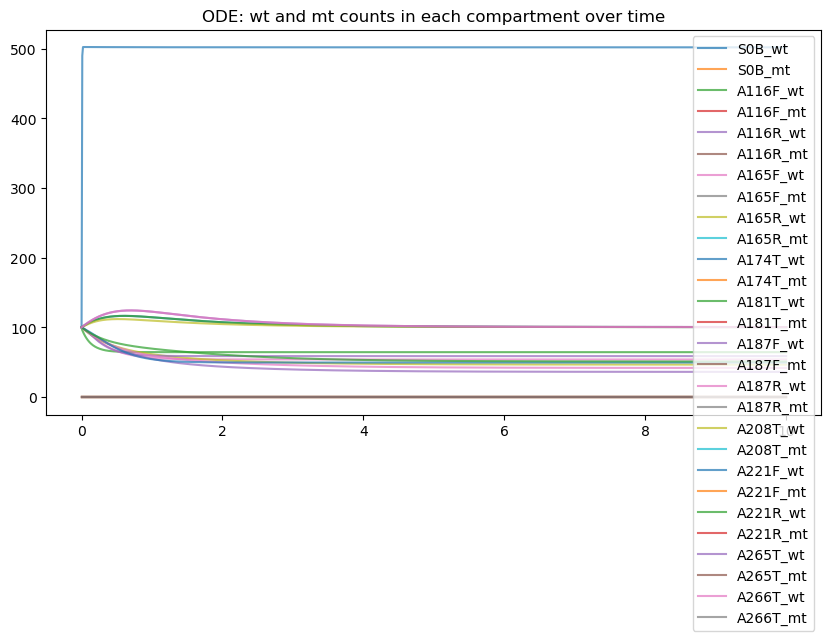

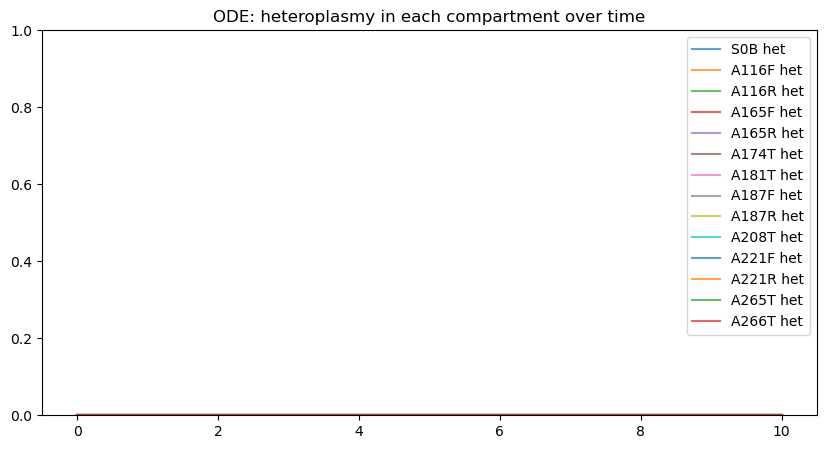

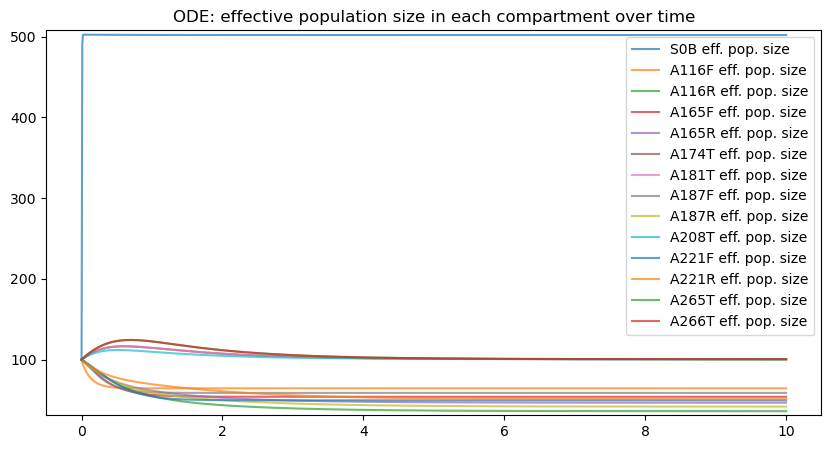

> Final counts of mt and wt in each compartment:
S0B_wt	502.0801	
S0B_mt	0.0	
A116F_wt	64.3785	
A116F_mt	0.0	
A116R_wt	36.0627	
A116R_mt	0.0	
A165F_wt	53.918	
A165F_mt	0.0	
A165R_wt	46.5201	
A165R_mt	0.0	
A174T_wt	100.4395	
A174T_mt	0.0	
A181T_wt	100.4395	
A181T_mt	0.0	
A187F_wt	58.7096	
A187F_mt	0.0	
A187R_wt	41.7348	
A187R_mt	0.0	
A208T_wt	100.4335	
A208T_mt	0.0	
A221F_wt	49.5099	
A221F_mt	0.0	
A221R_wt	50.9378	
A221R_mt	0.0	
A265T_wt	100.4464	
A265T_mt	0.0	
A266T_wt	100.4464	
A266T_mt	0.0	

> Final effective population sizes in each compartment:
S0B	502.0801	
A116F	64.3785	
A116R	36.0627	
A165F	53.918	
A165R	46.5201	
A174T	100.4395	
A181T	100.4395	
A187F	58.7096	
A187R	41.7348	
A208T	100.4335	
A221F	49.5099	
A221R	50.9378	
A265T	100.4464	
A266T	100.4464	


In [16]:
ODE_model = ODE_from_network(G, prnt=True)
plot_ODE(simulate_ode(ODE_model, TIME_POINTS, START_STATE), TIME_POINTS, DELTA, VARS, NODES)

In [17]:
# GILL_PARAM = gillespie_param_from_network(G)
# gillespie_results = simulate_gillespie(GILL_PARAM, TIME_POINTS, START_STATE, replicates=1000)
# plot_gillespie(gillespie_results, TIME_POINTS, DELTA, VARS, NODES)